 Install Required Libraries

In [1]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


 Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Preview:
     Category                  URL  \
0   Discovery    http://google.com   
1      People  http://facebook.com   
2      Videos   http://youtube.com   
3     Portals     http://yahoo.com   
4  Discussion   http://twitter.com   

                                         Description  
0  Google - Search the world's information, inclu...  
1  Welcome to Facebook - Facebook helps you conne...  
2  YouTube - Share your videos with friends, fami...  
3                                             Yahoo!  
4  Twitter - Instantly connect to what's most imp...  

Number of categories: 32

Sample count per category:
Category
Web              786
Commerce         405
News             312
Games            247
Technology       225
Education        221
Tools            207
Porn             201
Services         199
Style            172
Files            168
P

<ipython-input-4-bdc599d6e27e>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


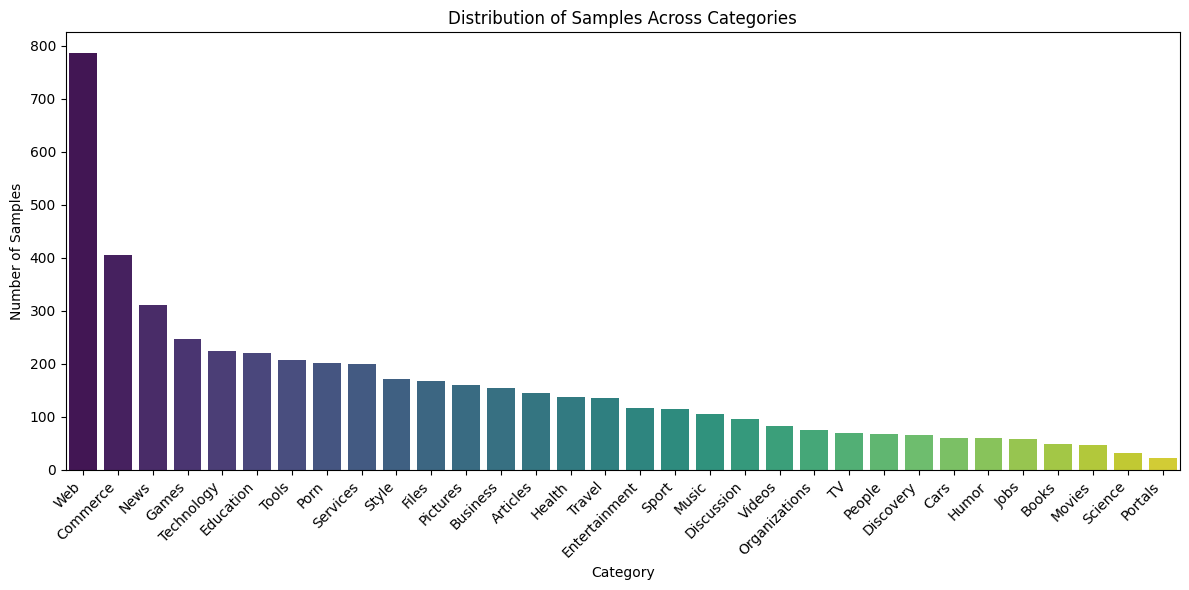

In [4]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset from Google Drive
file_path = '/content/drive/MyDrive/Dataset/website_dataset.csv'  # Replace with your dataset's path in Drive
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Dataset Preview:")
print(data.head())

# Check the number of categories and the distribution of samples in each category
category_counts = data['Category'].value_counts()

# Display the number of categories and their sample counts
num_categories = len(category_counts)
print(f"\nNumber of categories: {num_categories}")
print("\nSample count per category:")
print(category_counts)

#Plot the distribution of categories
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Distribution of Samples Across Categories")
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Dataset Preprocessing

In [5]:
import re

# Combine `url` and `description` into a single text feature
data['text'] = data['URL'] + " " + data['Description']

# Clean the text (optional: depending on the dataset)
# def clean_text(text):
#     # Remove special characters and multiple spaces
#     text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
#     text = re.sub(r"\s+", " ", text)
#     return text.strip()

# data['text'] = data['text'].apply(clean_text)

# Display a few samples of preprocessed text
# print("Preprocessed Text Samples:")
# print(data[['text', 'Category']].head())


Doing Encoding Task

In [7]:
import os
import json
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the `category` column
data['label'] = label_encoder.fit_transform(data['Category'])

# Create a mapping of categories to numerical labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Create a reverse mapping (numerical labels to original category names)
reverse_label_map = {value: key for key, value in label_mapping.items()}

#Display mappings
print("\nCategory to Label Mapping:")
for category, label in label_mapping.items():
    print(f"{category} -> {label}")

print("\nLabel to Category Mapping (Reverse):")
for label, category in reverse_label_map.items():
    print(f"{label} -> {category}")






Category to Label Mapping:
Articles -> 0
Books -> 1
Business -> 2
Cars -> 3
Commerce -> 4
Discovery -> 5
Discussion -> 6
Education -> 7
Entertainment -> 8
Files -> 9
Games -> 10
Health -> 11
Humor -> 12
Jobs -> 13
Movies -> 14
Music -> 15
News -> 16
Organizations -> 17
People -> 18
Pictures -> 19
Porn -> 20
Portals -> 21
Science -> 22
Services -> 23
Sport -> 24
Style -> 25
TV -> 26
Technology -> 27
Tools -> 28
Travel -> 29
Videos -> 30
Web -> 31

Label to Category Mapping (Reverse):
0 -> Articles
1 -> Books
2 -> Business
3 -> Cars
4 -> Commerce
5 -> Discovery
6 -> Discussion
7 -> Education
8 -> Entertainment
9 -> Files
10 -> Games
11 -> Health
12 -> Humor
13 -> Jobs
14 -> Movies
15 -> Music
16 -> News
17 -> Organizations
18 -> People
19 -> Pictures
20 -> Porn
21 -> Portals
22 -> Science
23 -> Services
24 -> Sport
25 -> Style
26 -> TV
27 -> Technology
28 -> Tools
29 -> Travel
30 -> Videos
31 -> Web


Splitting Here

In [9]:
from sklearn.model_selection import train_test_split

# Step 1: Split 75% for training and 25% for test+validation
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data['text'], data['label'], test_size=0.25, stratify=data['label'], random_state=42
)

# Step 2: Split the remaining 25% into 12.5% test and 12.5% validation
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Display the number of samples in each set
print(f"Training Set Size: {len(train_texts)}")
print(f"Validation Set Size: {len(val_texts)}")
print(f"Test Set Size: {len(test_texts)}")

# Check class distributions to verify stratification
train_class_distribution = pd.Series(train_labels).value_counts()
val_class_distribution = pd.Series(val_labels).value_counts()
test_class_distribution = pd.Series(test_labels).value_counts()

# print("\nClass Distribution in Training Set:")
# print(train_class_distribution)

# print("\nClass Distribution in Validation Set:")
# print(val_class_distribution)

# print("\nClass Distribution in Test Set:")
# print(test_class_distribution)


Training Set Size: 3750
Validation Set Size: 625
Test Set Size: 625


**BERT Base Model**

In [ ]:
from transformers import BertTokenizer

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("BERT Tokenizer Loaded.")


# Tokenize the training, validation, and test texts
train_encodings = tokenizer(
    list(train_texts), truncation=True, padding=True, max_length=128
)
val_encodings = tokenizer(
    list(val_texts), truncation=True, padding=True, max_length=128
)
test_encodings = tokenizer(
    list(test_texts), truncation=True, padding=True, max_length=128
)

print("Tokenization Completed for Training, Validation, and Test Sets.")




# Reset indices for labels and tokenized data
#Ensures that the labels align with their corresponding tokenized sequences after any preprocessing steps (like train/test splits).
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BERT Tokenizer Loaded.
Tokenization Completed for Training, Validation, and Test Sets.


Wrap Tokenized Data in a Custom Dataset Class

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    #Initializes the dataset with tokenized inputs (encodings) and labels.
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

        # Debugging: Ensure lengths match
        assert len(self.encodings['input_ids']) == len(self.labels), \
            "Mismatch between tokenized data and labels!"

    #Returns the total number of samples in the dataset.
    def __len__(self):
        return len(self.labels)


    #Fetches a single sample at a given index (idx).  A dictionary containing tokenized tensors (input_ids, attention_mask) and the corresponding label.
    def __getitem__(self, idx):
        try:
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item
        except IndexError as e:
            print(f"IndexError in __getitem__: {e}, idx: {idx}")
            raise



# Create datasets
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

print("Datasets and DataLoaders are ready.")

Datasets and DataLoaders are ready.


Load Pre-trained BERT Model for Sequence Classification

In [ ]:
from transformers import BertForSequenceClassification

# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(train_labels)))

# Move the model to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model loaded and moved to {device}.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cuda.


 Define Optimizer and Scheduler

In [ ]:
from transformers import AdamW, get_scheduler

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

epochs = 20  # Number of epochs

# Define learning rate scheduler
num_training_steps = len(train_loader) * epochs  # 3 epochs
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

print("Optimizer and scheduler are set.")


Optimizer and scheduler are set.


**Train the BERT**

In [ ]:
from tqdm import tqdm

# Training loop parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training phase
    model.train()
    train_loss = 0

    # Loop through batches in the training DataLoader
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # Move data to the device (GPU/CPU)
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss  # Loss is provided by the model

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accumulate training loss
        train_loss += loss.item()

        # Update progress bar
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            # Move data to the device
            batch = {key: val.to(device) for key, val in batch.items()}

            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            # Accumulate validation loss
            val_loss += loss.item()

            # CCalculates loss, predictions, and accuracy for the validation data.
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == batch['labels']).sum().item()
            total += batch['labels'].size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")



Epoch 1/20


Epoch 1: 100%|██████████| 235/235 [01:14<00:00,  3.15it/s, loss=1.9]


Average Training Loss: 2.1327
Validation Loss: 1.4962, Validation Accuracy: 0.6416

Epoch 2/20


Epoch 2: 100%|██████████| 235/235 [01:19<00:00,  2.95it/s, loss=0.998]


Average Training Loss: 1.0035
Validation Loss: 1.2516, Validation Accuracy: 0.6944

Epoch 3/20


Epoch 3: 100%|██████████| 235/235 [01:21<00:00,  2.87it/s, loss=0.91]


Average Training Loss: 0.5336
Validation Loss: 1.2319, Validation Accuracy: 0.7200

Epoch 4/20


Epoch 4: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.25]


Average Training Loss: 0.2587
Validation Loss: 1.3766, Validation Accuracy: 0.7040

Epoch 5/20


Epoch 5: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.598]


Average Training Loss: 0.1400
Validation Loss: 1.3749, Validation Accuracy: 0.7008

Epoch 6/20


Epoch 6: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.128]


Average Training Loss: 0.0836
Validation Loss: 1.4373, Validation Accuracy: 0.7248

Epoch 7/20


Epoch 7: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.229]


Average Training Loss: 0.0514
Validation Loss: 1.4835, Validation Accuracy: 0.7040

Epoch 8/20


Epoch 8: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.0103]


Average Training Loss: 0.0296
Validation Loss: 1.5980, Validation Accuracy: 0.7120

Epoch 9/20


Epoch 9: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.0239]


Average Training Loss: 0.0145
Validation Loss: 1.6085, Validation Accuracy: 0.7216

Epoch 10/20


Epoch 10: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.0108]


Average Training Loss: 0.0095
Validation Loss: 1.6459, Validation Accuracy: 0.7168

Epoch 11/20


Epoch 11: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.0133]


Average Training Loss: 0.0078
Validation Loss: 1.6814, Validation Accuracy: 0.7200

Epoch 12/20


Epoch 12: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.00706]


Average Training Loss: 0.0066
Validation Loss: 1.6976, Validation Accuracy: 0.7200

Epoch 13/20


Epoch 13: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.00747]


Average Training Loss: 0.0057
Validation Loss: 1.7280, Validation Accuracy: 0.7216

Epoch 14/20


Epoch 14: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.00795]


Average Training Loss: 0.0052
Validation Loss: 1.7519, Validation Accuracy: 0.7232

Epoch 15/20


Epoch 15: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.00579]


Average Training Loss: 0.0046
Validation Loss: 1.7721, Validation Accuracy: 0.7216

Epoch 16/20


Epoch 16: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.00404]


Average Training Loss: 0.0043
Validation Loss: 1.7905, Validation Accuracy: 0.7264

Epoch 17/20


Epoch 17: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.00353]


Average Training Loss: 0.0040
Validation Loss: 1.7973, Validation Accuracy: 0.7264

Epoch 18/20


Epoch 18: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.00387]


Average Training Loss: 0.0038
Validation Loss: 1.8067, Validation Accuracy: 0.7264

Epoch 19/20


Epoch 19: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.00391]


Average Training Loss: 0.0037
Validation Loss: 1.8115, Validation Accuracy: 0.7184

Epoch 20/20


Epoch 20: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s, loss=0.00237]


Average Training Loss: 0.0036
Validation Loss: 1.8131, Validation Accuracy: 0.7184


**Evaluate BERT**

In [ ]:
# Set the model to evaluation mode
model.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        # Move data to the device (GPU/CPU)
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Accumulate test loss
        test_loss += loss.item()

        # Compute accuracy
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == batch['labels']).sum().item()
        total += batch['labels'].size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


def predict_top5_categories(text, model, tokenizer, device, reverse_label_map):
    """
    Predict the top 5 categories for a given text using a fine-tuned BERT model.

    Args:
        text (str): The input text to classify.
        model (torch.nn.Module): The fine-tuned BERT model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer used with the model.
        device (torch.device): The device (CPU/GPU) where the model is loaded.
        reverse_label_map (dict): Reverse mapping of numerical labels to category names.

    Returns:
        list: Top 5 categories with their probabilities.
    """
    # Tokenize the input text
    encoding = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"  # Return PyTorch tensors
    )

    # Move tensors to the device
    encoding = {key: val.to(device) for key, val in encoding.items()}

    # Ensure the model is in evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    # Calculate probabilities using softmax
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()

    # Get top 5 probabilities and their indices
    top5_indices = torch.topk(torch.tensor(probabilities), 5).indices.tolist()
    top5_probs = torch.topk(torch.tensor(probabilities), 5).values.tolist()
    # Map indices to original category names
    top5_categories = [(reverse_label_map[idx], prob) for idx, prob in zip(top5_indices, top5_probs)]

    return top5_categories


Test Loss: 1.3662
Test Accuracy: 0.7552


In [ ]:
# Example input text
input_text = "Mbappe scored on his return from a thigh problem as Real Madrid beat Pachuca in midweek to win the Intercontinental Cup."
# Predict top 5 categories
top5_results = predict_top5_categories(input_text, model, tokenizer, device, reverse_label_map)

# Display the results
if top5_results:
    print("\nTop 5 Probable Categories:")
    for category, prob in top5_results:
        print(f"{category}: {prob:.4f}")


Top 5 Probable Categories:
Sport: 0.9965
Games: 0.0006
Portals: 0.0004
Style: 0.0003
Health: 0.0002


**Save Fine Tuned BERT**

In [ ]:
# Save the reverse label map as a JSON file
# Define the save directory
save_directory = "/content/drive/MyDrive/Saved Model"

# Convert keys of reverse_label_map to strings
reverse_label_map2 = {str(key): value for key, value in reverse_label_map.items()}

# Save the reverse label map to the correct path
reverse_label_map_path = f"{save_directory}/reverse_label_map-2.json"
with open(reverse_label_map_path, "w") as f:
    json.dump(reverse_label_map2, f)

print(f"Reverse label map saved to: {reverse_label_map_path}")
# Save the model's state dictionary in .pt format
save_path = "/content/drive/MyDrive/Saved Model/bert_finetuned_model-2.pt"
torch.save(model.state_dict(), save_path)
print(f"Model state dictionary saved to: {save_path}")


Reverse label map saved to: /content/drive/MyDrive/Saved Model/reverse_label_map-2.json
Model state dictionary saved to: /content/drive/MyDrive/Saved Model/bert_finetuned_model-2.pt


#** DistilBERT Work**

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Load the DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(reverse_label_map)
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the training, validation, and test texts
train_encodings = tokenizer(
    list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt"
)
val_encodings = tokenizer(
    list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt"
)
test_encodings = tokenizer(
    list(test_texts), truncation=True, padding=True, max_length=128, return_tensors="pt"
)

print("Tokenization Completed for Training, Validation, and Test Sets.")


Tokenization Completed for Training, Validation, and Test Sets.


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create PyTorch datasets
train_dataset = CustomDataset(train_encodings, train_labels.tolist())
val_dataset = CustomDataset(val_encodings, val_labels.tolist())
test_dataset = CustomDataset(test_encodings, test_labels.tolist())


In [ ]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

print("DataLoaders are ready.")


DataLoaders are ready.


In [ ]:
from transformers import AdamW, get_scheduler
from tqdm import tqdm

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 20
num_training_steps = len(train_loader) * epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        # Move batch to device
        batch = {key: val.to(device) for key, val in batch.items() if key != "token_type_ids"}  # Exclude token_type_ids

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accumulate loss
        train_loss += loss.item()

        # Update progress bar
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")



Epoch 1/20


Epoch 1: 100%|██████████| 235/235 [00:41<00:00,  5.64it/s, loss=0.543]


Average Training Loss: 2.0929
Epoch 2/20


Epoch 2: 100%|██████████| 235/235 [00:40<00:00,  5.76it/s, loss=1.04]


Average Training Loss: 0.9651
Epoch 3/20


Epoch 3: 100%|██████████| 235/235 [00:40<00:00,  5.76it/s, loss=0.268]


Average Training Loss: 0.5040
Epoch 4/20


Epoch 4: 100%|██████████| 235/235 [00:40<00:00,  5.74it/s, loss=0.0343]


Average Training Loss: 0.2545
Epoch 5/20


Epoch 5: 100%|██████████| 235/235 [00:40<00:00,  5.77it/s, loss=0.0109]


Average Training Loss: 0.1199
Epoch 6/20


Epoch 6: 100%|██████████| 235/235 [00:40<00:00,  5.76it/s, loss=0.0411]


Average Training Loss: 0.0712
Epoch 7/20


Epoch 7: 100%|██████████| 235/235 [00:40<00:00,  5.75it/s, loss=0.0184]


Average Training Loss: 0.0281
Epoch 8/20


Epoch 8: 100%|██████████| 235/235 [00:40<00:00,  5.75it/s, loss=0.0103]


Average Training Loss: 0.0150
Epoch 9/20


Epoch 9: 100%|██████████| 235/235 [00:40<00:00,  5.76it/s, loss=0.00332]


Average Training Loss: 0.0175
Epoch 10/20


Epoch 10: 100%|██████████| 235/235 [00:40<00:00,  5.76it/s, loss=0.0045]


Average Training Loss: 0.0157
Epoch 11/20


Epoch 11: 100%|██████████| 235/235 [00:40<00:00,  5.76it/s, loss=0.00496]


Average Training Loss: 0.0093
Epoch 12/20


Epoch 12: 100%|██████████| 235/235 [00:40<00:00,  5.77it/s, loss=0.00557]


Average Training Loss: 0.0063
Epoch 13/20


Epoch 13: 100%|██████████| 235/235 [00:40<00:00,  5.75it/s, loss=0.00142]


Average Training Loss: 0.0041
Epoch 14/20


Epoch 14: 100%|██████████| 235/235 [00:40<00:00,  5.75it/s, loss=0.00577]


Average Training Loss: 0.0035
Epoch 15/20


Epoch 15: 100%|██████████| 235/235 [00:40<00:00,  5.75it/s, loss=0.00146]


Average Training Loss: 0.0031
Epoch 16/20


Epoch 16: 100%|██████████| 235/235 [00:40<00:00,  5.76it/s, loss=0.00211]


Average Training Loss: 0.0028
Epoch 17/20


Epoch 17: 100%|██████████| 235/235 [00:40<00:00,  5.76it/s, loss=0.00119]


Average Training Loss: 0.0025
Epoch 18/20


Epoch 18: 100%|██████████| 235/235 [00:40<00:00,  5.75it/s, loss=0.00255]


Average Training Loss: 0.0024
Epoch 19/20


Epoch 19: 100%|██████████| 235/235 [00:40<00:00,  5.76it/s, loss=0.00169]


Average Training Loss: 0.0023
Epoch 20/20


Epoch 20: 100%|██████████| 235/235 [00:40<00:00,  5.76it/s, loss=0.00253]

Average Training Loss: 0.0023


In [ ]:
# Set the model to evaluation mode
model.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        # Move data to the device (GPU/CPU)
        batch = {key: val.to(device) for key, val in batch.items() if key != "token_type_ids"}  # Exclude token_type_ids

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Accumulate test loss
        test_loss += loss.item()

        # Compute accuracy
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == batch['labels']).sum().item()
        total += batch['labels'].size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.4514
Test Accuracy: 0.7424


In [ ]:
def predict_top5_categories(text, model, tokenizer, device, reverse_label_map):
    """
    Predict the top 5 categories for a given text using a fine-tuned DistilBERT model.

    Args:
        text (str): The input text to classify.
        model (torch.nn.Module): The fine-tuned DistilBERT model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer used with the model.
        device (torch.device): The device (CPU/GPU) where the model is loaded.
        reverse_label_map (dict): Reverse mapping of numerical labels to category names.

    Returns:
        list: Top 5 categories with their probabilities.
    """
    # Tokenize the input text
    encoding = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"  # Return PyTorch tensors
    )

    # Move tensors to the device
    encoding = {key: val.to(device) for key, val in encoding.items()}

    # Ensure the model is in evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    # Calculate probabilities using softmax
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()

    # Get top 5 probabilities and their indices
    top5_indices = torch.topk(torch.tensor(probabilities), 5).indices.tolist()
    top5_probs = torch.topk(torch.tensor(probabilities), 5).values.tolist()

    # Map indices to original category names
    top5_categories = [(reverse_label_map[idx], prob) for idx, prob in zip(top5_indices, top5_probs)]

    return top5_categories


In [ ]:
# Example input text
input_text = "the clisps was enjoyable"

# Predict top 5 categories
top5_results = predict_top5_categories(input_text, model, tokenizer, device, reverse_label_map)

# Display the results
if top5_results:
    print("\nTop 5 Probable Categories:")
    for category, prob in top5_results:
        print(f"{category}: {prob:.4f}")



Top 5 Probable Categories:
Videos: 0.2865
Discussion: 0.2184
Pictures: 0.1901
Files: 0.0583
Articles: 0.0559


**Saving DistilBERT**

In [ ]:
import json
import torch
from transformers import DistilBertTokenizer

# Define save directory
save_directory = "/content/drive/MyDrive/Saved Model"


# Save DistilBERT model's state dictionary
model_save_path = f"{save_directory}/distilbert_finetuned_model.pt"
torch.save(model.state_dict(), model_save_path)
print(f"DistilBERT model state dictionary saved to: {model_save_path}")



DistilBERT model state dictionary saved to: /content/drive/MyDrive/Saved Model/distilbert_finetuned_model.pt
